## Dependencies

In [1]:
import re
import warnings
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
contraction_mapping = {"trump's": 'trump is', "'cause": 'because', ',cause': 'because', ';cause': 'because', "ain't": 'am not', 'ain,t': 'am not', 'ain;t': 'am not', 
                       'ain´t': 'am not', 'ain’t': 'am not', "aren't": 'are not', 'aren,t': 'are not', 'aren;t': 'are not', 'aren´t': 'are not', 'aren’t': 'are not', 
                       "can't": 'cannot', "can't've": 'cannot have', 'can,t': 'cannot', 'can,t,ve': 'cannot have', 'can;t': 'cannot', 'can;t;ve': 'cannot have', 
                       'can´t': 'cannot', 'can´t´ve': 'cannot have', 'can’t': 'cannot', 'can’t’ve': 'cannot have', "could've": 'could have', 'could,ve': 'could have', 
                       'could;ve': 'could have', "couldn't": 'could not', "couldn't've": 'could not have', 'couldn,t': 'could not', 'couldn,t,ve': 'could not have', 
                       'couldn;t': 'could not', 'couldn;t;ve': 'could not have', 'couldn´t': 'could not', 'couldn´t´ve': 'could not have', 'couldn’t': 'could not', 
                       'couldn’t’ve': 'could not have', 'could´ve': 'could have', 'could’ve': 'could have', "didn't": 'did not', 'didn,t': 'did not', 'didn;t': 'did not', 
                       'didn´t': 'did not', 'didn’t': 'did not', "doesn't": 'does not', 'doesn,t': 'does not', 'doesn;t': 'does not', 'doesn´t': 'does not', 'doesn’t': 'does not', 
                       "don't": 'do not', 'don,t': 'do not', 'don;t': 'do not', 'don´t': 'do not', 'don’t': 'do not', "hadn't": 'had not', "hadn't've": 'had not have', 
                       'hadn,t': 'had not', 'hadn,t,ve': 'had not have', 'hadn;t': 'had not', 'hadn;t;ve': 'had not have', 'hadn´t': 'had not', 'hadn´t´ve': 'had not have', 
                       'hadn’t': 'had not', 'hadn’t’ve': 'had not have', "hasn't": 'has not', 'hasn,t': 'has not', 'hasn;t': 'has not', 'hasn´t': 'has not', 'hasn’t': 'has not', 
                       "haven't": 'have not', 'haven,t': 'have not', 'haven;t': 'have not', 'haven´t': 'have not', 'haven’t': 'have not', "he'd": 'he would', "he'd've": 'he would have', 
                       "he'll": 'he will', "he's": 'he is', 'he,d': 'he would', 'he,d,ve': 'he would have', 'he,ll': 'he will', 'he,s': 'he is', 'he;d': 'he would', 
                       'he;d;ve': 'he would have', 'he;ll': 'he will', 'he;s': 'he is', 'he´d': 'he would', 'he´d´ve': 'he would have', 'he´ll': 'he will', 'he´s': 'he is', 
                       'he’d': 'he would', 'he’d’ve': 'he would have', 'he’ll': 'he will', 'he’s': 'he is', "how'd": 'how did', "how'll": 'how will', "how's": 'how is', 
                       'how,d': 'how did', 'how,ll': 'how will', 'how,s': 'how is', 'how;d': 'how did', 'how;ll': 'how will', 'how;s': 'how is', 'how´d': 'how did', 'how´ll': 
                       'how will', 'how´s': 'how is', 'how’d': 'how did', 'how’ll': 'how will', 'how’s': 'how is', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 
                       'i have', 'i,d': 'i would', 'i,ll': 'i will', 'i,m': 'i am', 'i,ve': 'i have', 'i;d': 'i would', 'i;ll': 'i will', 'i;m': 'i am', 'i;ve': 'i have', 
                       "isn't": 'is not', 'isn,t': 'is not', 'isn;t': 'is not', 'isn´t': 'is not', 'isn’t': 'is not', "it'd": 'it would', "it'll": 'it will', "it's": 'it is', 
                       'it,d': 'it would', 'it,ll': 'it will', 'it,s': 'it is', 'it;d': 'it would', 'it;ll': 'it will', 'it;s': 'it is', 'it´d': 'it would', 'it´ll': 'it will', 
                       'it´s': 'it is', 'it’d': 'it would', 'it’ll': 'it will', 'it’s': 'it is', 'i´d': 'i would', 'i´ll': 'i will', 'i´m': 'i am', 'i´ve': 'i have', 'i’d': 'i would', 
                       'i’ll': 'i will', 'i’m': 'i am', 'i’ve': 'i have', "let's": 'let us', 'let,s': 'let us', 'let;s': 'let us', 'let´s': 'let us', 'let’s': 'let us', "ma'am": 'madam', 
                       'ma,am': 'madam', 'ma;am': 'madam', "mayn't": 'may not', 'mayn,t': 'may not', 'mayn;t': 'may not', 'mayn´t': 'may not', 'mayn’t': 'may not', 'ma´am': 'madam', 
                       'ma’am': 'madam', "might've": 'might have', 'might,ve': 'might have', 'might;ve': 'might have', "mightn't": 'might not', 'mightn,t': 'might not', 
                       'mightn;t': 'might not', 'mightn´t': 'might not', 'mightn’t': 'might not', 'might´ve': 'might have', 'might’ve': 'might have', "must've": 'must have', 
                       'must,ve': 'must have', 'must;ve': 'must have', "mustn't": 'must not', 'mustn,t': 'must not', 'mustn;t': 'must not', 'mustn´t': 'must not', 
                       'mustn’t': 'must not', 'must´ve': 'must have', 'must’ve': 'must have', "needn't": 'need not', 'needn,t': 'need not', 'needn;t': 'need not', 'needn´t': 'need not', 
                       'needn’t': 'need not', "oughtn't": 'ought not', 'oughtn,t': 'ought not', 'oughtn;t': 'ought not', 'oughtn´t': 'ought not', 'oughtn’t': 'ought not', 
                       "sha'n't": 'shall not', 'sha,n,t': 'shall not', 'sha;n;t': 'shall not', "shan't": 'shall not', 'shan,t': 'shall not', 'shan;t': 'shall not', 'shan´t': 'shall not', 
                       'shan’t': 'shall not', 'sha´n´t': 'shall not', 'sha’n’t': 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', 'she,d': 'she would', 
                       'she,ll': 'she will', 'she,s': 'she is', 'she;d': 'she would', 'she;ll': 'she will', 'she;s': 'she is', 'she´d': 'she would', 'she´ll': 'she will', 
                       'she´s': 'she is', 'she’d': 'she would', 'she’ll': 'she will', 'she’s': 'she is', "should've": 'should have', 'should,ve': 'should have', 
                       'should;ve': 'should have', "shouldn't": 'should not', 'shouldn,t': 'should not', 'shouldn;t': 'should not', 'shouldn´t': 'should not', 'shouldn’t': 'should not', 
                       'should´ve': 'should have', 'should’ve': 'should have', "that'd": 'that would', "that's": 'that is', 'that,d': 'that would', 'that,s': 'that is', 
                       'that;d': 'that would', 'that;s': 'that is', 'that´d': 'that would', 'that´s': 'that is', 'that’d': 'that would', 'that’s': 'that is', "there'd": 'there had', 
                       "there's": 'there is', 'there,d': 'there had', 'there,s': 'there is', 'there;d': 'there had', 'there;s': 'there is', 'there´d': 'there had', 'there´s': 'there is', 
                       'there’d': 'there had', 'there’s': 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', 
                       'they,d': 'they would', 'they,ll': 'they will', 'they,re': 'they are', 'they,ve': 'they have', 'they;d': 'they would', 'they;ll': 'they will', 
                       'they;re': 'they are', 'they;ve': 'they have', 'they´d': 'they would', 'they´ll': 'they will', 'they´re': 'they are', 'they´ve': 'they have', 
                       'they’d': 'they would', 'they’ll': 'they will', 'they’re': 'they are', 'they’ve': 'they have', "wasn't": 'was not', 'wasn,t': 'was not', 'wasn;t': 'was not', 
                       'wasn´t': 'was not', 'wasn’t': 'was not', "we'd": 'we would', "we'll": 'we will', "we're": 'we are', "we've": 'we have', 'we,d': 'we would', 'we,ll': 'we will', 
                       'we,re': 'we are', 'we,ve': 'we have', 'we;d': 'we would', 'we;ll': 'we will', 'we;re': 'we are', 'we;ve': 'we have', "weren't": 'were not', 'weren,t': 'were not', 
                       'weren;t': 'were not', 'weren´t': 'were not', 'weren’t': 'were not', 'we´d': 'we would', 'we´ll': 'we will', 'we´re': 'we are', 'we´ve': 'we have', 
                       'we’d': 'we would', 'we’ll': 'we will', 'we’re': 'we are', 'we’ve': 'we have', "what'll": 'what will', "what're": 'what are', "what's": 'what is', 
                       "what've": 'what have', 'what,ll': 'what will', 'what,re': 'what are', 'what,s': 'what is', 'what,ve': 'what have', 'what;ll': 'what will', 'what;re': 'what are', 
                       'what;s': 'what is', 'what;ve': 'what have', 'what´ll': 'what will', 'what´re': 'what are', 'what´s': 'what is', 'what´ve': 'what have', 'what’ll': 'what will', 
                       'what’re': 'what are', 'what’s': 'what is', 'what’ve': 'what have', "where'd": 'where did', "where's": 'where is', 'where,d': 'where did', 'where,s': 'where is', 
                       'where;d': 'where did', 'where;s': 'where is', 'where´d': 'where did', 'where´s': 'where is', 'where’d': 'where did', 'where’s': 'where is', "who'll": 'who will', 
                       "who's": 'who is', 'who,ll': 'who will', 'who,s': 'who is', 'who;ll': 'who will', 'who;s': 'who is', 'who´ll': 'who will', 'who´s': 'who is', 'who’ll': 'who will', 
                       'who’s': 'who is', "won't": 'will not', 'won,t': 'will not', 'won;t': 'will not', 'won´t': 'will not', 'won’t': 'will not', "wouldn't": 'would not', 
                       'wouldn,t': 'would not', 'wouldn;t': 'would not', 'wouldn´t': 'would not', 'wouldn’t': 'would not', "you'd": 'you would', "you'll": 'you will', 
                       "you're": 'you are', 'you,d': 'you would', 'you,ll': 'you will', 'you,re': 'you are', 'you;d': 'you would', 'you;ll': 'you will', 'you;re': 'you are', 
                       'you´d': 'you would', 'you´ll': 'you will', 'you´re': 'you are', 'you’d': 'you would', 'you’ll': 'you will', 'you’re': 'you are', '´cause': 'because', 
                       '’cause': 'because', "you've": 'you have', "could'nt": 'could not', "havn't": 'have not', 'here’s': 'here is', 'i""m': 'i am', "i'am": 'i am', "i'l": 'i will', 
                       "i'v": 'i have', "wan't": 'want', "was'nt": 'was not', "who'd": 'who would', "who're": 'who are', "who've": 'who have', "why'd": 'why would', 
                       "would've": 'would have', "y'all": 'you all', "y'know": 'you know', 'you.i': 'you i', "your'e": 'you are', "arn't": 'are not', "agains't": 'against', 
                       "c'mon": 'common', "doens't": 'does not', 'don""t': 'do not', "dosen't": 'does not', "dosn't": 'does not', "shoudn't": 'should not', "that'll": 'that will', 
                       "there'll": 'there will', "there're": 'there are', "this'll": 'this all', "u're": 'you are', "ya'll": 'you all', "you'r": 'you are', 'you’ve': 'you have', 
                       "d'int": 'did not', "did'nt": 'did not', "din't": 'did not', "dont't": 'do not', "gov't": 'government', "i'ma": 'i am', "is'nt": 'is not', '‘i': 'i', 
                       'ᴀɴᴅ': 'and', 'ᴛʜᴇ': 'the', 'ʜᴏᴍᴇ': 'home', 'ᴜᴘ': 'up', 'ʙʏ': 'by', 'ᴀᴛ': 'at', '…and': 'and', 'civilbeat': 'civil beat', 'trumpcare': 'trump care', 
                       'obamacare': 'obama care', 'ᴄʜᴇᴄᴋ': 'check', 'ғᴏʀ': 'for', 'ᴛʜɪs': 'this', 'ᴄᴏᴍᴘᴜᴛᴇʀ': 'computer', 'ᴍᴏɴᴛʜ': 'month', 'ᴡᴏʀᴋɪɴɢ': 'working', 'ᴊᴏʙ': 'job', 
                       'ғʀᴏᴍ': 'from', 'sᴛᴀʀᴛ': 'start', 'gubmit': 'submit', 'co₂': 'carbon dioxide', 'ғɪʀsᴛ': 'first', 'ᴇɴᴅ': 'end', 'ᴄᴀɴ': 'can', 'ʜᴀᴠᴇ': 'have', 'ᴛᴏ': 'to', 
                       'ʟɪɴᴋ': 'link', 'ᴏғ': 'of', 'ʜᴏᴜʀʟʏ': 'hourly', 'ᴡᴇᴇᴋ': 'week', 'ᴇxᴛʀᴀ': 'extra', 'gʀᴇᴀᴛ': 'great', 'sᴛᴜᴅᴇɴᴛs': 'student', 'sᴛᴀʏ': 'stay', 'ᴍᴏᴍs': 'mother', 
                       'ᴏʀ': 'or', 'ᴀɴʏᴏɴᴇ': 'anyone', 'ɴᴇᴇᴅɪɴɢ': 'needing', 'ᴀɴ': 'an', 'ɪɴᴄᴏᴍᴇ': 'income', 'ʀᴇʟɪᴀʙʟᴇ': 'reliable', 'ʏᴏᴜʀ': 'your', 'sɪɢɴɪɴɢ': 'signing', 
                       'ʙᴏᴛᴛᴏᴍ': 'bottom', 'ғᴏʟʟᴏᴡɪɴɢ': 'following', 'mᴀᴋᴇ': 'make', 'ᴄᴏɴɴᴇᴄᴛɪᴏɴ': 'connection', 'ɪɴᴛᴇʀɴᴇᴛ': 'internet', 'financialpost': 'financial post', 
                       'ʜaᴠᴇ': ' have ', 'ᴄaɴ': ' can ', 'maᴋᴇ': ' make ', 'ʀᴇʟɪaʙʟᴇ': ' reliable ', 'ɴᴇᴇᴅ': ' need ', 'ᴏɴʟʏ': ' only ', 'ᴇxᴛʀa': ' extra ', 'aɴ': ' an ', 
                       'aɴʏᴏɴᴇ': ' anyone ', 'sᴛaʏ': ' stay ', 'sᴛaʀᴛ': ' start', 'shopo': 'shop', "aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", 
                       "couldnt" : "could not", "didn't" : "did not", "doesn't" : "does not", "doesnt" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not",
                       "haven't" : "have not", "havent" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", 
                       "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have","let's" : "let us", "mightn't" : "might not", 
                       "mustn't" : "must not","shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", 
                       "shouldnt" : "should not", "that's" : "that is", "thats" : "that is", "there's" : "there is", "theres" : "there is", "they'd" : "they would",
                       "they'll" : "they will", "they're" : "they are", "theyre":  "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", 
                       "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have",
                       "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", 
                       "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", 
                       "we'll":" will", "didn't": "did not", "tryin'":"trying"}

def map_contraction(x):
    for m in contraction_mapping:
        x = x.replace(m, contraction_mapping[m])  
    return x

In [5]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

## Train/validation sets

In [6]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']

X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [7]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 3
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

# Model

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

In [9]:
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
embedding_title = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_title)

input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
embedding_body = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_body)

input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
embedding_answer = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_answer)

x = Concatenate()([embedding_title, embedding_body, embedding_answer])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
______________________________________________________________________________________________

# Train model

In [10]:
optimizer = optimizers.Adam(LEARNING_RATE)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid))
callback_list = [es, rlrop, spearmanCallback]
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/40
Train spearman-rho: 0.2121 Validation spearman-rho: 0.1988
4863/4863 - 33s - loss: 0.4912 - val_loss: 0.4143
Epoch 2/40
Train spearman-rho: 0.2887 Validation spearman-rho: 0.2705
4863/4863 - 24s - loss: 0.4070 - val_loss: 0.3991
Epoch 3/40
Train spearman-rho: 0.3291 Validation spearman-rho: 0.3068
4863/4863 - 24s - loss: 0.3961 - val_loss: 0.3919
Epoch 4/40
Train spearman-rho: 0.3527 Validation spearman-rho: 0.3240
4863/4863 - 24s - loss: 0.3898 - val_loss: 0.3876
Epoch 5/40
Train spearman-rho: 0.3706 Validation spearman-rho: 0.3349
4863/4863 - 24s - loss: 0.3857 - val_loss: 0.3849
Epoch 6/40
Train spearman-rho: 0.3844 Validation spearman-rho: 0.3414
4863/4863 - 23s - loss: 0.3823 - val_loss: 0.3829
Epoch 7/40
Train spearman-rho: 0.3950 Validation spearman-rho: 0.3460
4863/4863 - 24s - loss: 0.3804 - val_loss: 0.3814
Epoch 8/40
Train spearman-rho: 0.4042 Validation spearman-rho: 0.3490
4863/4863 - 24s - loss: 0.3774 - val_loss:

## Model loss graph

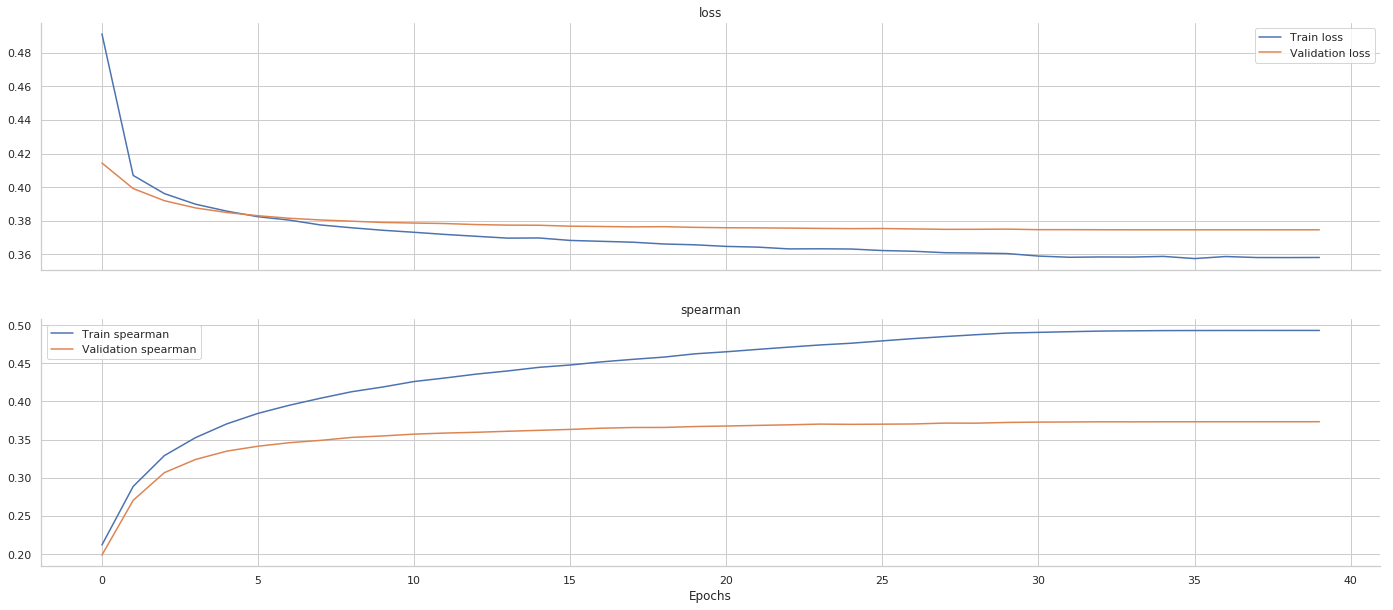

In [11]:
sns.set(style="whitegrid")
for key in spearmanCallback.history.keys():
    history[key] = spearmanCallback.history[key]

plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [12]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.493,0.373
1,question_asker_intent_understanding,0.472,0.400
2,question_body_critical,0.714,0.623
3,question_conversational,0.461,0.407
4,question_expect_short_answer,0.511,0.263
5,question_fact_seeking,0.534,0.339
6,question_has_commonly_accepted_answer,0.557,0.421
7,question_interestingness_others,0.454,0.393
8,question_interestingness_self,0.595,0.529
9,question_multi_intent,0.590,0.437


## By category

In [13]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.461,0.337,0.504,0.373,0.395,0.198,0.519,0.41,0.517,0.382


#### Save model weights

In [14]:
model.save_weights(model_path)